# Evaluate trained models

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib

import predicting_APMALDI_response.evaluation_utils as evaluation_utils

# plt.style.use('dark_background')
plt.style.use('default')

### 1. Specify task to evaluate (to be updated update)
Specify which task to evaluate: `detection_per_mol_sum` or `regression_on_detected_per_mol_sum`

In [16]:
# TASK_NAME = "detection_per_mol_sum"
TASK_NAME = "regression_on_detected_per_mol_sum"

# Name of the experiment where to find the training predictions (by default in `training_results/paper_results`):
# EXP_NAME = "paper_results"
EXP_NAME = "new_random_experiments"

### 2. Import training predictions and compute scores

In [17]:
plots_dir = Path.cwd() / "./plots" / EXP_NAME / TASK_NAME
plots_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path.cwd() / "./training_results" / EXP_NAME / TASK_NAME
raw_intensities_csv = Path.cwd() / "./training_data/intensity_data_raw.csv"


In [18]:
OUR_MODEL_NAME = "NeuralNet"

selected_model = "MLP"
plots_dir.mkdir(exist_ok=True, parents=True)

filenames = {
    OUR_MODEL_NAME: "results_mol_feat.csv",
    "Baseline": "results_random_feat.csv",
}

formatted_metric_names = {
    "macro_avg_f1_score": "Macro-Avg-F1 Score",
    "Spearman's R": "Spearman's R",
    "Pearson's R": "Pearson's Correlation Coefficient (r)",
    "RMSE": "Root Mean Squared Error (RMSE)"
}

In [19]:
if "detection" in TASK_NAME:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
    pval_metric = None
    task_typename = "classification"
elif "regression" in TASK_NAME or "rank" in TASK_NAME:
    # metric = "Spearman's R"
    # pval_metric = "S pval"
    metric = "Pearson's R"
    pval_metric = "P pval"
    # metric = "RMSE"
    # pval_metric = None
    count_key = 'non-zero obs'
    task_typename = "regression"
else:
    raise ValueError(TASK_NAME)



In [20]:
molecules_with_zero_charge = evaluation_utils.get_molecules_with_zero_formal_charge(
    raw_intensities_csv)

In [21]:
# GLOBAL_STRING = r"\textbf{Global}"
GLOBAL_STRING = "Global"
# Compute the actual scores:
model_metrics, models_predictions, model_typename = evaluation_utils.compute_scores(
    filenames, TASK_NAME, task_typename,
    eval_feat_selection=False,
    has_multiple_iterations=True,
    name_global_column=GLOBAL_STRING,
    molecules_with_zero_charge=molecules_with_zero_charge,
    results_dir=results_dir)


In [22]:
index_columns = ["matrix", "polarity", "train_setup", "model_type",
                 "adduct_setup"]

# Take avg and std over multiple iterations:
std_metrics = model_metrics.groupby(index_columns, as_index=True).std().drop(
    columns="iter_index")
mean_metrics = model_metrics.groupby(index_columns, as_index=True).mean().drop(
    columns="iter_index")
mean_metrics = mean_metrics.join(std_metrics, lsuffix='_mean',
                                 rsuffix='_std').reset_index()

In [23]:
# model_metrics

In [24]:
if pval_metric is not None:
    model_metrics["Significant"] = model_metrics[pval_metric] < 0.05
    model_metrics[index_columns + ["Significant"]].value_counts()

### Scatter plots predictions

In [11]:
import seaborn as sns

predictions_csv = results_dir / "results_mol_feat.csv"
predictions_csv_random = results_dir / "results_random_feat.csv"
predictions_df = pd.read_csv(predictions_csv, index_col=0)
predictions_df["train_setup"] = OUR_MODEL_NAME
predictions_random_df = pd.read_csv(predictions_csv_random, index_col=0)
predictions_random_df["train_setup"] = "Baseline"

# Merge predictions:
predictions_df = pd.concat([predictions_df, predictions_random_df])

predictions_df.drop(columns=["fold"], inplace=True)

In [205]:
# Average multiple predictions:
predictions_df = predictions_df.groupby([model_typename, 'name_short', 'matrix',
       'polarity', 'train_setup'], as_index=False).mean()
predictions_df.drop(columns=["iter_index"], inplace=True)

In [206]:
predictions_df["matrix_pol"] = predictions_df["matrix"] + "_" + predictions_df[
    "polarity"]

In [208]:
chosen_polarity = "negative"
# [predictions_df.polarity == "negative"]
# predictions_df.plot.scatter(x='Measured intensity (log10[intensity+1])',
#                             y='Predicted intensity (log10[intensity+1])',
#                             c=predictions_df.matrix_pol)


if task_typename == "regression":
    masked_prediction_df = predictions_df[(predictions_df.polarity == chosen_polarity) &
                                          (predictions_df['observed_value']>0) ]
    masked_prediction_df.loc[masked_prediction_df['prediction'].isna(), 'prediction'] = 0

    g = sns.FacetGrid(masked_prediction_df,
                      hue="matrix",
                      col='train_setup',
                      # row=optim_param_keys[1]
                      height=6,
                      )
    g.map_dataframe(sns.scatterplot,
                   x='observed_value',
                   y='prediction',
                    # hue="matrix_pol",
                   # palette="dark",
                    alpha=.6,
                   # height=6
                   )
    g.add_legend()
    plt.show()

    g = sns.FacetGrid(masked_prediction_df,
                      hue='train_setup',
                      col="matrix",
                      # row=optim_param_keys[1],
                      col_wrap=4,
                      height=4,
                      )
    g.map_dataframe(sns.scatterplot,
                   x='observed_value',
                   y='prediction',
                    # hue="matrix_pol",
                   # palette="dark",
                    alpha=.6,
                   # height=6
                   )
    g.add_legend()
    plt.show()

In [209]:
if task_typename == "classification":
    # Threshold the average predictions from multiple models:
    predictions_df.loc[:, "prediction"] = predictions_df["prediction"] > 0.5
    predictions_df.loc[:, "observed_value"] = predictions_df["observed_value"] > 0.5
    predictions_df = predictions_df[predictions_df.polarity == chosen_polarity]
    predictions_df = predictions_df[predictions_df.train_setup == "Baseline"]
    value_counts = predictions_df[["train_setup", "matrix", "polarity", "observed_value", "prediction"]].value_counts()
    value_counts = value_counts.reset_index()
    value_counts["counts"] = value_counts[0].astype("int")
    # value_counts

    g = sns.FacetGrid(value_counts,
                  # hue="train_setup",
                  col='matrix',
                  col_wrap=5,
                  # height=6,
                  )
    for (row_i, col_j, cue), data_ijk in g.facet_data():
        ax = g.facet_axis(row_i, col_j)
        # print(data_ijk)
        pivot = data_ijk.pivot(index='observed_value', columns='prediction', values='counts').fillna(0).astype("int")

        sns.heatmap(pivot, ax=ax,
                    square=True,
                    annot=True,
                    fmt="d"
                    )
        # sns.scatterplot(data=data_ijk,
        #            x='observed_value',
        #            y='prediction',
        #             # hue="matrix_pol",
        #            # palette="dark",
        #             s=data_ijk['counts'].to_numpy(),
        #             alpha=.6,
        #            # height=6
        #            )
    # g.map_dataframe(sns.scatterplot,
    #                x='observed_value',
    #                y='prediction',
    #                 # hue="matrix_pol",
    #                # palette="dark",
    #                 s='data',
    #                 alpha=.6,
    #                # height=6
    #                )
    g.add_legend()
    plt.show()

    value_counts = predictions_df[["train_setup", "observed_value", "prediction"]].value_counts()
    value_counts = value_counts.reset_index()
    value_counts["counts"] = value_counts[0]
    # value_counts

    pivot = value_counts.pivot(index='observed_value', columns='prediction', values='counts')
    sns.heatmap(pivot,
                # ax=ax,
                    square=True,
                annot=True,
                fmt='d'
                    )


,train_setup,matrix,polarity,observed_value,prediction,0,counts
0,Baseline,MAPS,negative,False,False,99,99
1,Baseline,9AA,negative,True,True,87,87
2,Baseline,NEDC,negative,False,False,87,87
3,Baseline,CMBT,negative,False,False,79,79
4,Baseline,DAN,negative,True,True,75,75
5,Baseline,NOR,negative,True,True,74,74
6,Baseline,ClCCA,negative,False,False,58,58
7,Baseline,pNA,negative,True,True,54,54
8,Baseline,DHB,negative,False,False,51,51
9,Baseline,CHCA,negative,True,False,45,45


### 3. Plot the achieved scores
By default, plots will be saved in the directory `./plots/<EXP_NAME>/<TASK_NAME>`

In [25]:
# ecolors = [
#     '#0C7BDC',
#     '#FFC20A',
#     'lightblue'
# ]
ecolors = {
    OUR_MODEL_NAME: '#0C7BDC',
    "Baseline": '#FFC20A',
}

dot_colors = [
    'black',
    'black',
    'black',
    # 'orange',
    # 'mediumpurple',
    # 'blue',
]

global_labels = {
    "": "All",
    "positive": "Positive",
    "negative": "Negative"
}

polarity_labels = {
    "positive": "Positive",
    "negative": "Negative"
}


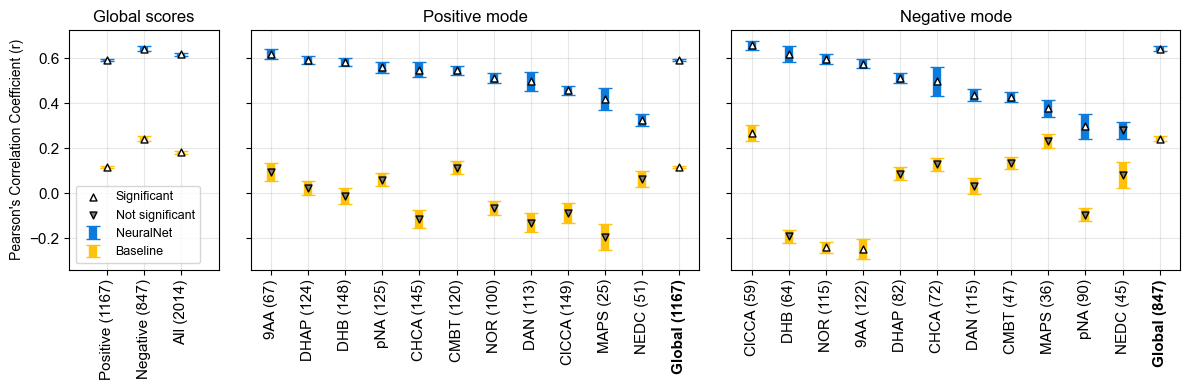

In [26]:
from matplotlib import rc

# rc('font', **{'family': 'serif', 'serif': ['Arial']})
# rc('text', usetex=False)
# plt.rcParams.update({'font.size': 10})

# Parameters suggested by Veronika:
rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':10})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)


fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4),
                         sharey=True,
                         gridspec_kw={'width_ratios': [1, 3, 3]})
axes = np.array([axes])

error_bars_kwargs = {"linestyle": "none",
                     "elinewidth": 6,
                     "capsize": 5,
                     "fmt": '' if pval_metric is not None else ".",
                     "markeredgecolor": 'black',
                    "markerfacecolor": "white",
                     "markersize": 5 if pval_metric is not None else 9
                     }
# ecolors = {
#     True: "blue",
#     False: "red"
# }

plt.xticks(rotation='vertical')
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=11)
    # ax.set_xticks(rotation='vertical')

for pol_idx, polarity in enumerate(["positive", "negative"]):
    ax = axes[0, pol_idx + 1]
    filtered_metrics = mean_metrics[
        mean_metrics.polarity == polarity].sort_values(metric + '_mean',
                                                       ascending=False)
    # print(f"Plot results for task {TASK_NAME}:")
    # plt.rcParams.update({'font.size': 16})
    # mean_metrics["Matrix (polarity)"] = mean_metrics["matrix"] + " (" + mean_metrics["polarity"] + ")"

    # fig.tight_layout(h_pad=3, w_pad=2)
    # fig.savefig(plots_dir / f"{task_typename}_global_plot.pdf")
    #
    sorted_matrices = filtered_metrics[
        filtered_metrics.train_setup == OUR_MODEL_NAME].sort_values(
        metric + '_mean', ascending=False).matrix.reset_index(drop=True)
    # Move the global score at the end:
    target_row = sorted_matrices[sorted_matrices == GLOBAL_STRING].index.item()
    idx = [i for i in range(len(sorted_matrices)) if i != target_row] + [
        target_row]
    sorted_matrices = sorted_matrices.iloc[idx]
    # print(sorted_matrices)

    filtered_metrics = filtered_metrics.sort_values('train_setup',
                                                    ascending=False)
    for i, (train_setup, rows) in enumerate(
            filtered_metrics.groupby("train_setup", sort=False)):
        # print(rows)
        df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
        if task_typename == "regression":
            x_labels = pd.Series(
                sorted_matrices.astype("str").to_numpy() + " (" + df_to_plot[
                    "non-zero obs_mean"].astype("int").astype(
                    "str").to_numpy() + ")",
                index=sorted_matrices.index)
        else:
            x_labels = sorted_matrices

        ax.errorbar(x_labels.to_numpy(),
                    df_to_plot[metric + '_mean'].to_numpy(),
                    yerr=df_to_plot[metric + '_std'].to_numpy(),
                    color=dot_colors[i], ecolor=ecolors[train_setup],
                    label=train_setup, **error_bars_kwargs)
        ax.get_xticklabels()[-1].set_weight("bold")
        if pval_metric is not None:
            not_significant = df_to_plot[pval_metric + '_mean'] > 0.05
            # not_significant_labels = x_labels[not_significant]
            ax.scatter(x_labels.to_numpy()[~not_significant], df_to_plot[metric + '_mean'].to_numpy()[~not_significant],
                       marker='^',
                       s=25,
                       color="white",
                       label="Significant" if i == 0 else None,
                       edgecolor='black',
                       zorder=3)
            ax.scatter(x_labels.to_numpy()[not_significant], df_to_plot[metric + '_mean'].to_numpy()[not_significant],
                       marker='v',
                       s=25,
                       color="gray",
                       edgecolor='black',
                       label="Not significant" if i == 0 else None,
                       zorder=3)
        # else:
        #     ax.scatter(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(),
        #                marker='.',
        #                s=25,
        #                color="white",
        #                label="Significant" if i == 0 else None,
        #                edgecolor='black',
        #                zorder=3)


        # # Add a line separating the global results:
        # ax.axvline(x=10.5)

    # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
    # ax.legend(loc="best", prop={'size': 7})
    # ax.set_xlabel("Matrix type")
    # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3,
            # axis='y'
            )
    ax.set_title(f"{polarity_labels[polarity]} mode")
    plt.sca(ax)
    plt.xticks(rotation=90)

# ----------------------
# Global scores, plot scores:
# ----------------------
ax = axes[0, 0]
ax.set_ylabel(formatted_metric_names[metric])

filtered_metrics = mean_metrics[
    mean_metrics.matrix == GLOBAL_STRING].sort_values(metric + '_mean',
                                                      ascending=False)
x_labels = pd.Series(
    [global_labels[pol] for pol in filtered_metrics["polarity"]]).astype("str")
if task_typename == "regression":
    x_labels = x_labels.to_numpy() + " (" + filtered_metrics[
        "non-zero obs_mean"].astype("int").astype(
        "str").to_numpy() + ")"
else:
    x_labels = x_labels.to_numpy()
filtered_metrics["Matrix and polarity"] = pd.Series(x_labels,
                                                    index=filtered_metrics.index)
# filtered_metrics["Matrix and polarity"] = filtered_metrics["polarity"] + " polarity"
# filtered_metrics.loc[filtered_metrics.polarity == "", "Matrix and polarity"] = "All matrices"
# print(f"Plot results for task {TASK_NAME}:")

filtered_metrics = filtered_metrics.sort_values("Matrix and polarity",
                                                ascending=False)

for i, (train_setup, rows) in enumerate(
        filtered_metrics.groupby("train_setup", sort=False)):
    # print(train_setup)
    # df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
    # if task_typename == "regression":
    #     x_labels =  pd.Series(sorted_matrices.astype("str").to_numpy() + "(" + df_to_plot["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")",
    #                                 index=sorted_matrices.index)
    # else:
    #     x_labels = sorted_matrices

    # ax.errorbar(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(), yerr=df_to_plot[metric+'_std'].to_numpy(),
    #             color = dot_colors[i], ecolor = ecolors[i],
    #           label=train_setup, **error_bars_kwargs)

    p = ax.errorbar("Matrix and polarity", metric + '_mean',
                    yerr=metric + '_std', data=rows,
                    color=dot_colors[i], ecolor=ecolors[train_setup],
                    label=train_setup, **error_bars_kwargs)
    if pval_metric is not None:
        ax.scatter("Matrix and polarity", metric + '_mean',
               data=rows,
               marker='^',
               s=25,
               color="white",
               edgecolor='black',
               zorder=3,
               label="Significant" if i == 0  else None)
        ax.scatter("Matrix and polarity", metric + '_mean',
               data=rows.iloc[[]],
               marker='v',
               s=25,
               color="grey",
               edgecolor='black',
               zorder=3,
               label="Not significant" if i == 0  else None)



    # # Add a line separating the global results:
    # ax.axvline(x=10.5)

# mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
ax.legend(loc="best", prop={'size': 9})
# ax.set_ylabel(formatted_metric_names[metric])

# ax.set_xlabel("Matrix type")
# ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
# ylims = [0.3, 0.8]
# ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
ax.grid(visible=True, alpha=0.3,
        # axis='y'
        )
ax.set_xlim(-1, 3)
ax.set_title("Global scores")
plt.sca(ax)
plt.xticks(rotation=90)

# axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,1])
# axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,2])

# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,1])
# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,2])


fig.tight_layout(h_pad=2, w_pad=1)
fig.savefig(plots_dir / f"{task_typename}_scores.pdf")
fig.savefig(plots_dir / f"{task_typename}_scores.png", dpi=400)


In [15]:
plots_dir

PosixPath('/Users/alberto-mac/EMBL_repos/spotting-project-regression/plots/new_random_experiments/detection_per_mol_sum')